In [1]:
import sys
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt,pi
import matplotlib.pyplot as plt
import math
import datetime
from scipy import stats
import seaborn as sns
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,RidgeCV,LassoCV,ElasticNetCV
from sklearn.metrics import mean_squared_error
import random




In [2]:
van = pd.read_csv('listings.csv.gz')

In [3]:
van.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4330 entries, 0 to 4329
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4330 non-null   int64  
 1   listing_url                                   4330 non-null   object 
 2   scrape_id                                     4330 non-null   int64  
 3   last_scraped                                  4330 non-null   object 
 4   name                                          4330 non-null   object 
 5   description                                   4300 non-null   object 
 6   neighborhood_overview                         3034 non-null   object 
 7   picture_url                                   4330 non-null   object 
 8   host_id                                       4330 non-null   int64  
 9   host_url                                      4330 non-null   o

In [4]:
van = van[['latitude','longitude','price','bedrooms','host_neighbourhood','number_of_reviews','review_scores_rating','property_type']]

In [5]:
van = van.dropna()

In [6]:
## Have to convert price from currency object to float
## CONVERT STRING DOLLAR SIGN TO FLOAT 
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

van['price'] = van['price'].apply(clean_currency).astype('float')

## Exploratory Analysis 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

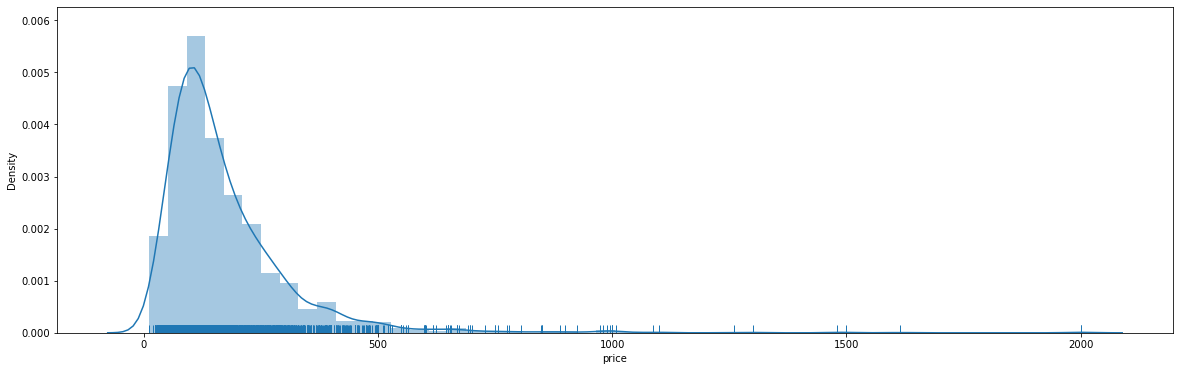

In [7]:
plt.figure(figsize=(20,6))
sns.distplot(van['price'],rug=True)

<AxesSubplot:title={'center':'price'}, xlabel='property_type'>

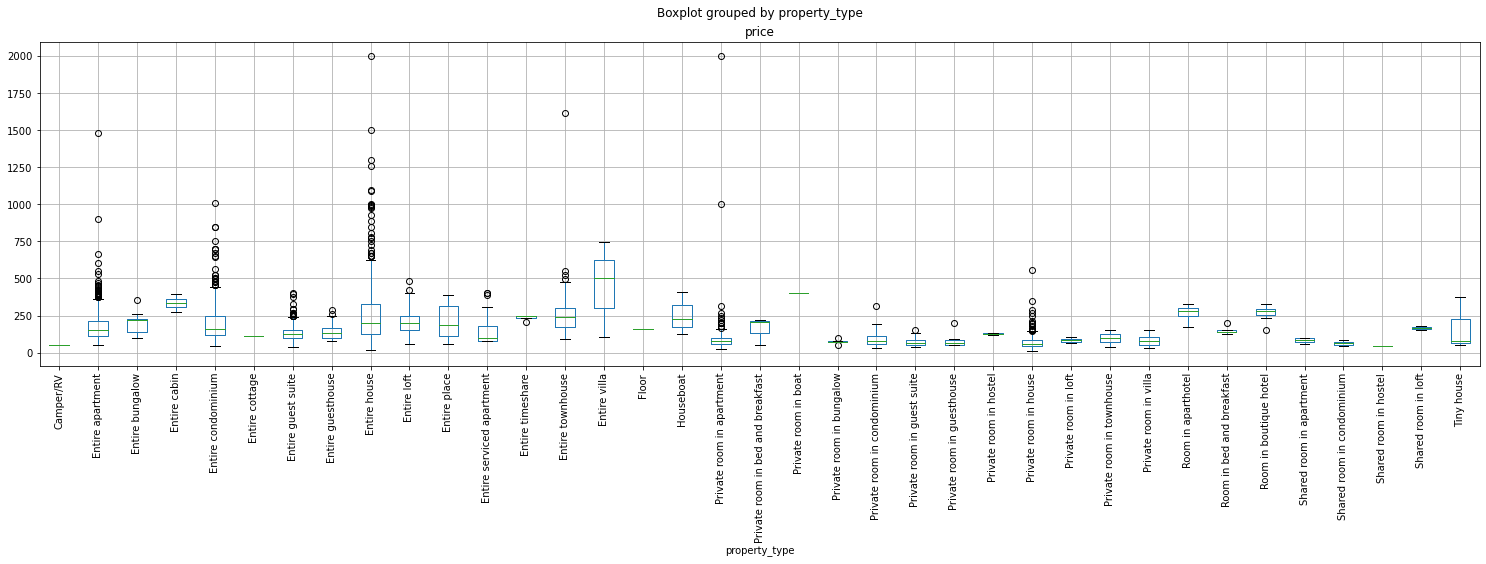

In [8]:
## box plot comparing price with room type 
van.boxplot(column='price',by='property_type',figsize=(25,6),rot=90)


<AxesSubplot:title={'center':'price'}, xlabel='host_neighbourhood'>

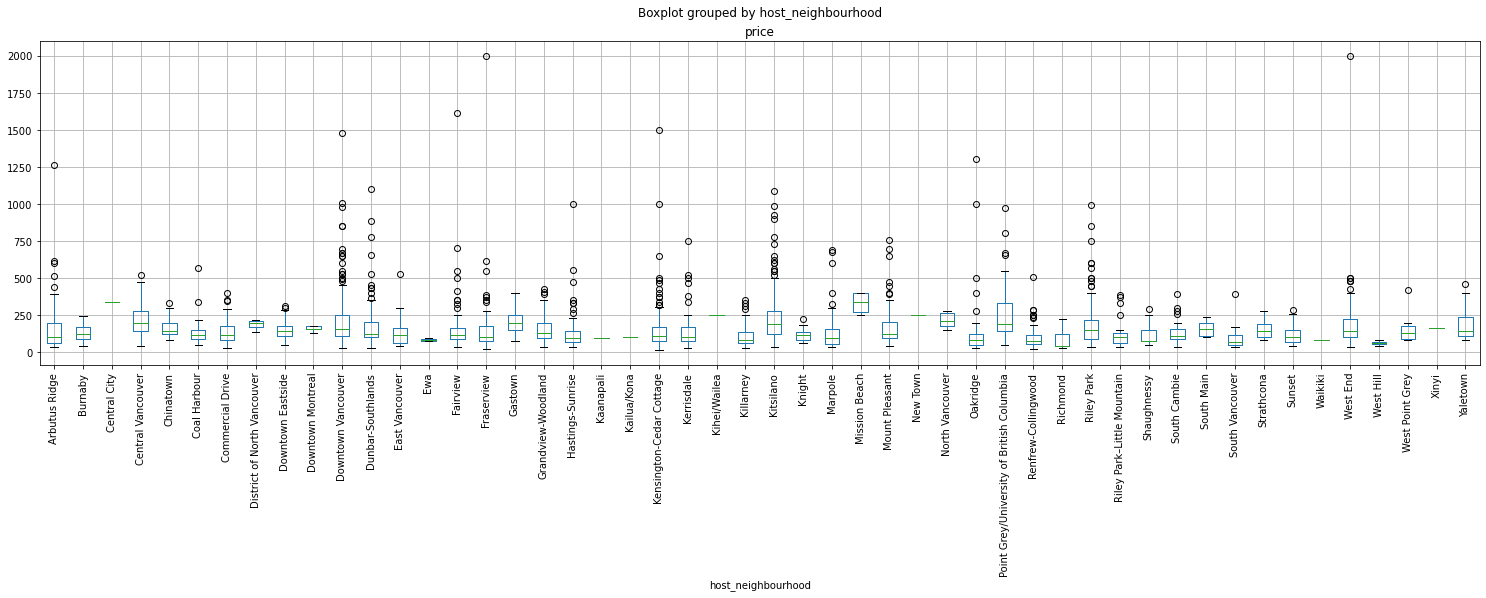

In [9]:
## box plot comparing price neighborhood type
van.boxplot(column='price',by='host_neighbourhood',figsize=(25,6),rot=90)   

In [10]:
van.describe()
#van.info()

,latitude,longitude,price,bedrooms,number_of_reviews,review_scores_rating
count,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000
mean,49.263232,-123.111155,174.651666,1.593610,40.148746,4.721597
std,0.019505,0.038510,146.198186,0.874661,62.388420,0.566714
min,49.202960,-123.217570,12.000000,1.000000,1.000000,0.000000
25%,49.250900,-123.129330,90.000000,1.000000,4.000000,4.680000
50%,49.267310,-123.114620,135.000000,1.000000,16.000000,4.860000
75%,49.279145,-123.087390,215.500000,2.000000,51.000000,5.000000
max,49.294360,-123.022480,2000.000000,8.000000,662.000000,5.000000


In [11]:
print(sorted(van['host_neighbourhood'].unique())) ## Sorted Neigborhoods
print(len(van['host_neighbourhood'].unique())) ## number of Neighborhoods
## I think i am loosing the orignal number of neigborhoods of 61 when removing nulls NEED TO REVISIT 

['Arbutus Ridge', 'Burnaby', 'Central City', 'Central Vancouver', 'Chinatown', 'Coal Harbour', 'Commercial Drive', 'District of North Vancouver', 'Downtown Eastside', 'Downtown Montreal', 'Downtown Vancouver', 'Dunbar-Southlands', 'East Vancouver', 'Ewa', 'Fairview', 'Fraserview', 'Gastown', 'Grandview-Woodland', 'Hastings-Sunrise', 'Kaanapali', 'Kailua/Kona', 'Kensington-Cedar Cottage', 'Kerrisdale', 'Kihei/Wailea', 'Killarney', 'Kitsilano', 'Knight', 'Marpole', 'Mission Beach', 'Mount Pleasant', 'New Town', 'North Vancouver', 'Oakridge', 'Point Grey/University of British Columbia', 'Renfrew-Collingwood', 'Richmond', 'Riley Park', 'Riley Park–Little Mountain', 'Shaughnessy', 'South Cambie', 'South Main', 'South Vancouver', 'Strathcona', 'Sunset', 'Waikiki', 'West End', 'West Hill', 'West Point Grey', 'Xinyi', 'Yaletown']
50


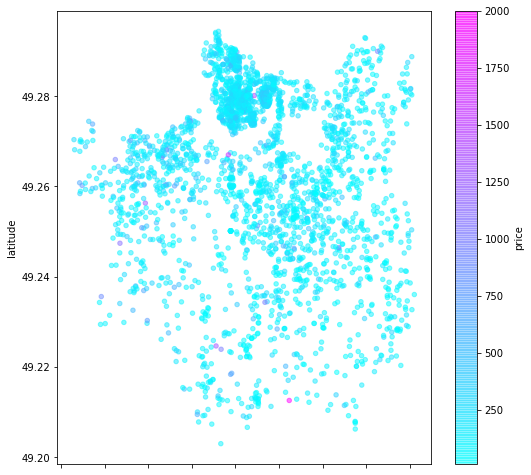

In [12]:
van.plot.scatter(x='longitude',y='latitude',c='price',figsize=(10,10),cmap='cool',alpha=0.5)
plt.subplots_adjust(bottom=.25, left=.25)
## NEED TO LOWER THE PRICE SINCE THE EXPENSIVE ONES ARE NOT VISIBLE BECAUSE OF THE OUTLIERS

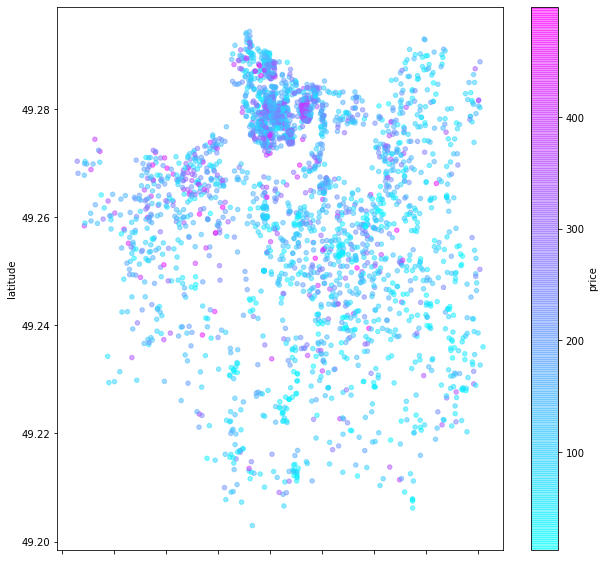

In [13]:
van[van['price']<500].plot.scatter(x='longitude',y='latitude',c='price',figsize=(10,10),cmap='cool',alpha=0.5)
## EXPENSIVE ONES ARE SCATTERED 
van = van[van['price']<500]


## REVIEWS 

<AxesSubplot:xlabel='review_scores_rating', ylabel='price'>

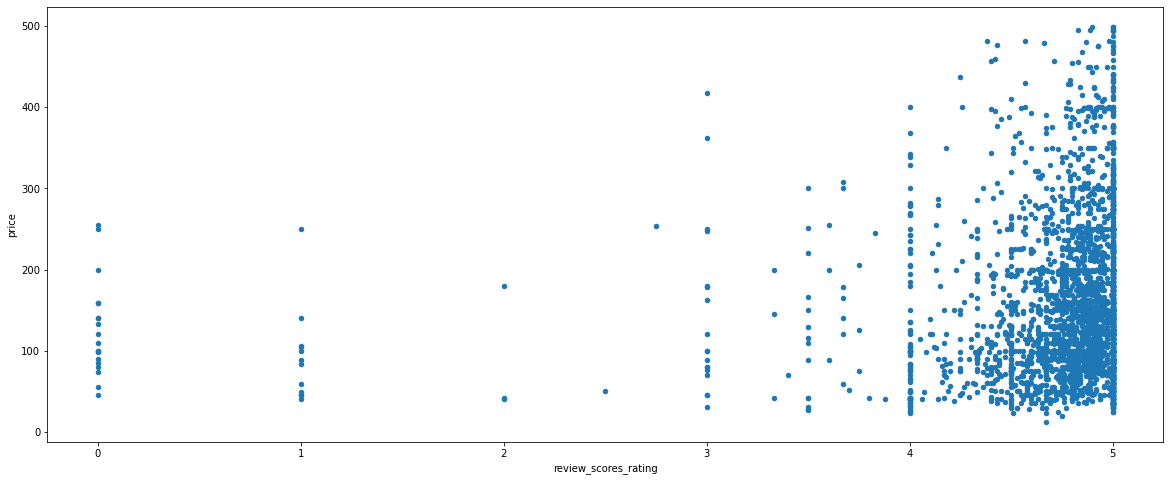

In [14]:
van.plot.scatter(x='review_scores_rating',y='price',figsize=(20,8))

<AxesSubplot:xlabel='number_of_reviews', ylabel='price'>

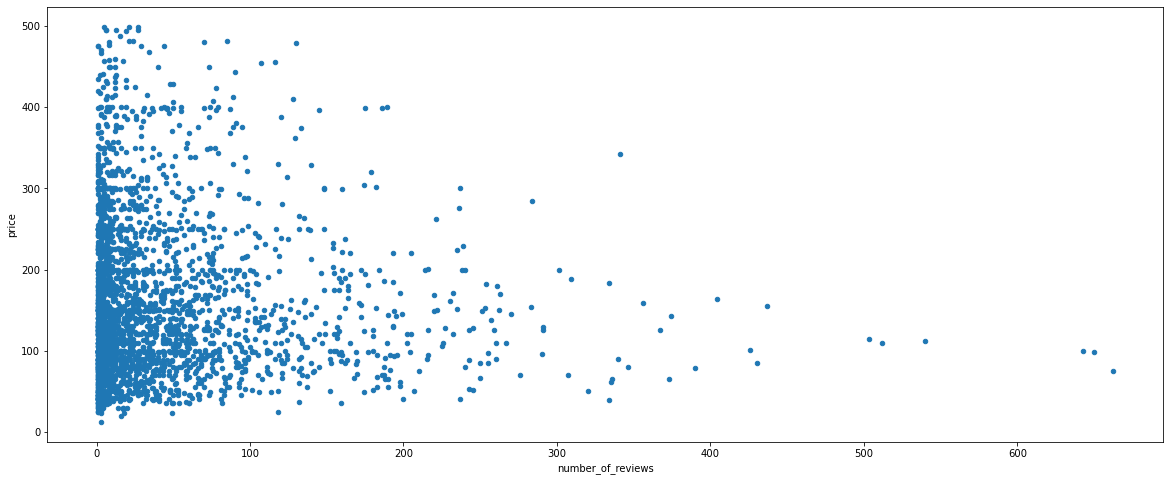

In [15]:
van.plot.scatter(x='number_of_reviews',y='price',figsize=(20,8))


## BEDROOMS 

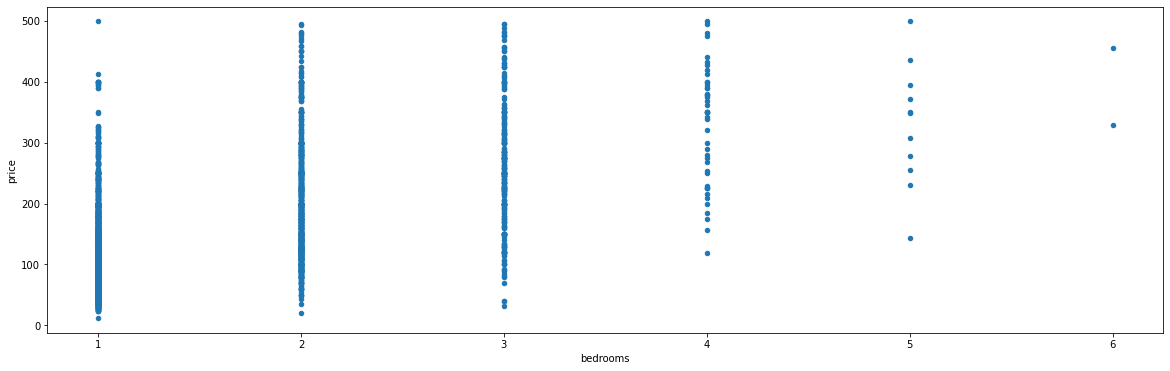

In [16]:
van.plot.scatter(x='bedrooms',y='price',figsize=(20,6));
## DOES NOT TELL US MUCH 

## Modelling


In [17]:
data = van.copy()
data = pd.get_dummies(data) ## We have to encode the neigborhood into encoded variables 
data.head()

,latitude,longitude,price,bedrooms,number_of_reviews,review_scores_rating,host_neighbourhood_Arbutus Ridge,host_neighbourhood_Burnaby,host_neighbourhood_Central City,host_neighbourhood_Central Vancouver,...,property_type_Private room in townhouse,property_type_Private room in villa,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Shared room in apartment,property_type_Shared room in condominium,property_type_Shared room in hostel,property_type_Shared room in loft,property_type_Tiny house
0,49.28872,-123.12046,150.0,2.0,16,4.64,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,49.28201,-123.12669,85.0,1.0,430,4.67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,49.25622,-123.06607,140.0,1.0,89,4.91,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,49.24922,-123.08139,150.0,1.0,33,4.75,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,49.27721,-123.04086,195.0,2.0,5,4.80,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X = data.copy().drop('price',axis = 1)
y = data['price'].copy()

In [19]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y)

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_valid)
X_train_scaled = scaler.transform(X_train)

In [21]:
baseline = y_train.median()
baseline_error = np.sqrt(mean_squared_error(y_pred=np.ones_like(y_valid)* baseline,y_true = y_valid))
baseline_error

95.36036022733666

### Standard error of +/- 106.03 for the prices of AirBnb

## Machine learning

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler()
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.transform(X_train)

baseline = y_train.median() #median train
print('Median costs '+ str(baseline))


baseline_error = np.sqrt(mean_squared_error(y_pred=np.ones_like(y_test) * baseline, y_true=y_test))
print('basline error +- ' + str(baseline_error))

Median costs 133.0
basline error +- 94.42347956750523


In [23]:
### ALPHA AND l1-ratio https://www.youtube.com/watch?v=9WisRGpP4p4&t=1624s&ab_channel=JoseMartinez12
lr = LinearRegression()
alphas = [1000, 100, 50, 20, 10, 1, 0.1, 0.01]
l1_ratios = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
ridge = RidgeCV(alphas=alphas)
lasso = LassoCV(alphas=alphas, max_iter=10000)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)

for model, name in zip([lr, ridge, lasso, elastic], ['LinearRegression', 'Ridge','lasso','ElasticNet']):
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    mrse_train = np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true=y_train))
    y_pred = model.predict(X_test_scaled)
    mrse_test = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    print(name + ' mrse_train:' + str(mrse_train) + ', mrse_test: ' + str(mrse_test))

LinearRegression mrse_train:64.97798885111625, mrse_test: 13521230703855.182
Ridge mrse_train:65.03176461791982, mrse_test: 65.8150117878401
lasso mrse_train:65.49930917317296, mrse_test: 65.9622636978085
ElasticNet mrse_train:65.76876389458707, mrse_test: 66.15538925968893


## Linear Regression gives a terrible error 
## Ridge we get a reasonable result 
## Lasso gives the best answer 

In [24]:
pf = PolynomialFeatures(degree=2)
pf.fit(X_train_scaled)
X_test_scaled = pf.transform(X_test_scaled)
X_train_scaled = pf.transform(X_train_scaled)

In [25]:
for model, name in zip([lr, ridge], ['LinearRegression', 'Ridge']):
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    mrse_train = np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true=y_train))
    y_pred = model.predict(X_test_scaled)
    mrse_test = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    print(name + ' mrse_train: ' + str(mrse_train) + ', mrse_test: ' + str(mrse_test))


LinearRegression mrse_train: 56.54736432065633, mrse_test: 79309850447629.39
Ridge mrse_train: 60.88021990006192, mrse_test: 66.90588063526062
